<a href="https://colab.research.google.com/github/akhilp90/Direction-Forecasting-In-Financial-Markets-Using-Machine-Learning/blob/main/DirectionForecastingInFinancialMarkets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read all 50 different stock csv files and combine the data

In [1]:
import pandas as pd
import os
from glob import glob

# Root folder where files are placed in Colab
folder_path = '/content/'

# Collect all CSV files in the root
csv_files = glob(os.path.join(folder_path, '*.csv'))

# Generate correct date range (weekdays only)
date_range = pd.bdate_range(start='2024-06-05', end='2025-06-05')

# List to store each processed DataFrame
all_data = []

for file_path in csv_files:
    try:
        # Read the file
        df = pd.read_csv(file_path)

        # Overwrite the existing Date column with the generated date range
        df['Date'] = date_range[:len(df)]

        # Extract ticker from filename (e.g., "AAPL Historical Data.csv" → "AAPL")
        filename = os.path.basename(file_path)
        ticker = filename.split(' ')[0].upper()

        # Add a ticker column
        df['ticker'] = ticker

        all_data.append(df)

    except Exception as e:
        print(f"❌ Error with file {file_path}: {e}")

# Combine all the data
final_df = pd.concat(all_data, ignore_index=True)

# Preview
print(f"✅ Combined DataFrame shape: {final_df.shape}")
print(final_df.head())


✅ Combined DataFrame shape: (11768, 8)
        Date   Price    Open    High     Low   Vol. Change % ticker
0 2024-06-05  295.93  297.81  298.65   295.8  1.84M   -0.49%    AXP
1 2024-06-06  297.39   295.2  298.25  292.65  2.20M    0.70%    AXP
2 2024-06-07  295.33  292.35  295.74  290.33  1.75M    0.44%    AXP
3 2024-06-10  294.05  294.97  295.75  291.63  5.25M   -0.45%    AXP
4 2024-06-11  295.38  296.26  296.61   292.8  2.36M    0.69%    AXP


Install Pandas_ta library

In [1]:
!pip uninstall -y numpy pandas_ta
!pip install numpy==1.23.5 pandas_ta


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 64.1 MB/s eta 0:00:00
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=98027d21dc50db0d8aefc2cd24f577c920fed7280efe71f658d6435da86b3a3a
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
bigframes 2.8.0 requires numpy>=1.24.0, but you

Feature Engineer 36 parameters/features which effect stock price moment from OHLCV data

In [2]:
import pandas as pd
import pandas_ta as ta

# Clean all price-related columns
for col in ['Price', 'Open', 'High', 'Low']:
    final_df[col] = final_df[col].replace('[\$,]', '', regex=True).astype(float)

# Clean volume separately (because it may have 'M', 'B', 'K')
def parse_volume(x):
    if isinstance(x, str):
        x = x.strip()
        if x.endswith('B'):
            return float(x[:-1]) * 1_000_000_000
        elif x.endswith('M'):
            return float(x[:-1]) * 1_000_000
        elif x.endswith('K'):
            return float(x[:-1]) * 1_000
        else:
            return float(x.replace(',', ''))
    return x

final_df['Volume'] = final_df['Vol.'].apply(parse_volume).astype(float)

# Initial cleaning
final_df['Close'] = final_df['Price'].replace('[\$,]', '', regex=True).astype(float)
final_df['Date'] = pd.to_datetime(final_df['Date'], format='%m/%d/%Y')
final_df = final_df.sort_values(['ticker', 'Date']).reset_index(drop=True)

# Feature engineering function
def add_features(df):
    close = df['Close']
    volume = df['Volume']

    # Technical Indicators
    df['RSI_14'] = ta.rsi(close, length=14)
    macd = ta.macd(close)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_hist'] = macd['MACDh_12_26_9']
    df['EMA_20'] = ta.ema(close, length=20)
    bb = ta.bbands(close, length=20)
    df[['BBL', 'BBM', 'BBU']] = bb[['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0']]

    # Lag Features
    for lag in [1, 3, 5]:
        df[f'lag_close_{lag}'] = close.shift(lag)
        df[f'lag_volume_{lag}'] = volume.shift(lag)

    # Rolling Stats
    for window in [5, 10, 20]:
        df[f'rolling_mean_{window}'] = close.rolling(window).mean()
        df[f'rolling_std_{window}'] = close.rolling(window).std()
        df[f'zscore_{window}'] = (close - df[f'rolling_mean_{window}']) / df[f'rolling_std_{window}']

    # Momentum / ROC
    df['ROC_10'] = ta.roc(close, length=10)
    df['momentum_10'] = close - close.shift(10)
    df['acceleration'] = df['momentum_10'] - df['momentum_10'].shift(1)

    # Candle Features
    if {'Open', 'High', 'Low'}.issubset(df.columns):
        df['candle_body'] = abs(df['Close'] - df['Open'])
        df['upper_shadow'] = df['High'] - df[['Close', 'Open']].max(axis=1)
        df['lower_shadow'] = df[['Close', 'Open']].min(axis=1) - df['Low']

    # Volume Features
    df['vol_rolling_mean_10'] = volume.rolling(10).mean()
    df['vol_roc_10'] = ta.roc(volume, length=10)

    # Price Ratios
    if {'High', 'Low'}.issubset(df.columns):
        df['hl_ratio'] = df['High'] / df['Low']
        df['oc_ratio'] = df['Open'] / df['Close']

    return df

# Apply per stock
final_df = final_df.groupby('ticker').apply(add_features).reset_index(drop=True)

# Drop any rows with NaNs created by rolling or lag
final_df.dropna(inplace=True)

print(final_df.head(3))


         Date   Price    Open    High     Low     Vol. Change % ticker  \
33 2024-07-22  194.27  198.36  200.70  192.37   59.73M   -3.89%   AAPL   
34 2024-07-23  202.14  201.85  203.51  199.80   51.34M   -0.19%   AAPL   
35 2024-07-24  202.52  211.44  212.94  201.16  101.35M    2.21%   AAPL   

         Volume   Close  ...    ROC_10  momentum_10  acceleration  \
33   59730000.0  194.27  ... -8.930246       -19.05        -10.68   
34   51340000.0  202.14  ... -4.875294       -10.36          8.69   
35  101350000.0  202.52  ... -4.114389        -8.69          1.67   

    candle_body  upper_shadow  lower_shadow  vol_rolling_mean_10  vol_roc_10  \
33         4.09          2.34          1.90           47793000.0    4.113648   
34         0.29          1.37          2.05           47698000.0   -1.816791   
35         8.92          1.50          1.36           54150000.0  175.183275   

    hl_ratio  oc_ratio  
33  1.043302  1.021053  
34  1.018569  0.998565  
35  1.058560  1.044045  

[3 r

/tmp/ipython-input-2-2899138138.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = final_df.groupby('ticker').apply(add_features).reset_index(drop=True)


Understand shape of the dataframe and get all parameters name

In [3]:
# ✅ Get the shape of the DataFrame
print(f"Shape of final_df: {final_df.shape}")  # (rows, columns)

# ✅ Get all column names
print("Column names in final_df:")
print(final_df.columns.tolist())


Shape of final_df: (9966, 43)
Column names in final_df:
['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'ticker', 'Volume', 'Close', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist', 'EMA_20', 'BBL', 'BBM', 'BBU', 'lag_close_1', 'lag_volume_1', 'lag_close_3', 'lag_volume_3', 'lag_close_5', 'lag_volume_5', 'rolling_mean_5', 'rolling_std_5', 'zscore_5', 'rolling_mean_10', 'rolling_std_10', 'zscore_10', 'rolling_mean_20', 'rolling_std_20', 'zscore_20', 'ROC_10', 'momentum_10', 'acceleration', 'candle_body', 'upper_shadow', 'lower_shadow', 'vol_rolling_mean_10', 'vol_roc_10', 'hl_ratio', 'oc_ratio']


Generate UniqueId called StockId for each stock

In [4]:
# Get unique tickers
unique_tickers = final_df['ticker'].unique()

# Create a mapping from ticker to stock_id
ticker_to_id = {ticker: idx for idx, ticker in enumerate(unique_tickers)}

# Map ticker column to stock_id column
final_df['stock_id'] = final_df['ticker'].map(ticker_to_id)


Check Stock_Id implementation

In [5]:
final_df.head(-10)

,Date,Price,Open,High,Low,Vol.,Change %,ticker,Volume,Close,...,momentum_10,acceleration,candle_body,upper_shadow,lower_shadow,vol_rolling_mean_10,vol_roc_10,hl_ratio,oc_ratio,stock_id
33,2024-07-22,194.27,198.36,200.70,192.37,59.73M,-3.89%,AAPL,59730000.0,194.27,...,-19.05,-10.68,4.09,2.34,1.90,47793000.0,4.113648,1.043302,1.021053,0
34,2024-07-23,202.14,201.85,203.51,199.80,51.34M,-0.19%,AAPL,51340000.0,202.14,...,-10.36,8.69,0.29,1.37,2.05,47698000.0,-1.816791,1.018569,0.998565,0
35,2024-07-24,202.52,211.44,212.94,201.16,101.35M,2.21%,AAPL,101350000.0,202.52,...,-8.69,1.67,8.92,1.50,1.36,54150000.0,175.183275,1.058560,1.044045,0
36,2024-07-25,198.15,186.10,199.54,186.06,87.44M,4.06%,AAPL,87440000.0,198.15,...,-11.99,-3.30,12.05,1.39,0.04,59020000.0,125.709861,1.072450,0.939187,0
37,2024-07-26,190.42,189.07,194.78,183.00,121.88M,-4.24%,AAPL,121880000.0,190.42,...,-18.86,-6.87,1.35,4.36,6.07,67386000.0,218.890633,1.064372,0.992910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11753,2025-04-30,114.41,114.39,114.82,113.14,15.77M,0.03%,XOM,15770000.0,114.41,...,1.16,-0.47,0.02,0.41,1.25,13789000.0,20.565749,1.014849,0.999825,45
11754,2025-05-01,114.37,114.11,114.55,113.46,16.21M,0.28%,XOM,16210000.0,114.37,...,2.45,1.29,0.26,0.18,0.65,14410000.0,62.100000,1.009607,0.997727,45
11755,2025-05-02,114.05,111.64,114.53,111.64,16.27M,2.97%,XOM,16270000.0,114.05,...,3.11,0.66,2.41,0.48,0.00,14864000.0,38.704177,1.025887,0.978869,45
11756,2025-05-05,110.76,111.90,112.69,110.76,52.22M,-0.88%,XOM,52220000.0,110.76,...,-1.42,-4.53,1.14,0.79,0.00,18751000.0,291.161049,1.017425,1.010293,45


Check for Missing Values

In [5]:
missing_values = final_df.isnull().sum()
print(missing_values)


Date                   0
Price                  0
Open                   0
High                   0
Low                    0
Vol.                   0
Change %               0
ticker                 0
Volume                 0
Close                  0
RSI_14                 0
MACD                   0
MACD_signal            0
MACD_hist              0
EMA_20                 0
BBL                    0
BBM                    0
BBU                    0
lag_close_1            0
lag_volume_1           0
lag_close_3            0
lag_volume_3           0
lag_close_5            0
lag_volume_5           0
rolling_mean_5         0
rolling_std_5          0
zscore_5               0
rolling_mean_10        0
rolling_std_10         0
zscore_10              0
rolling_mean_20        0
rolling_std_20         0
zscore_20              0
ROC_10                 0
momentum_10            0
acceleration           0
candle_body            0
upper_shadow           0
lower_shadow           0
vol_rolling_mean_10    0


Box Plot each parameters to understand the data

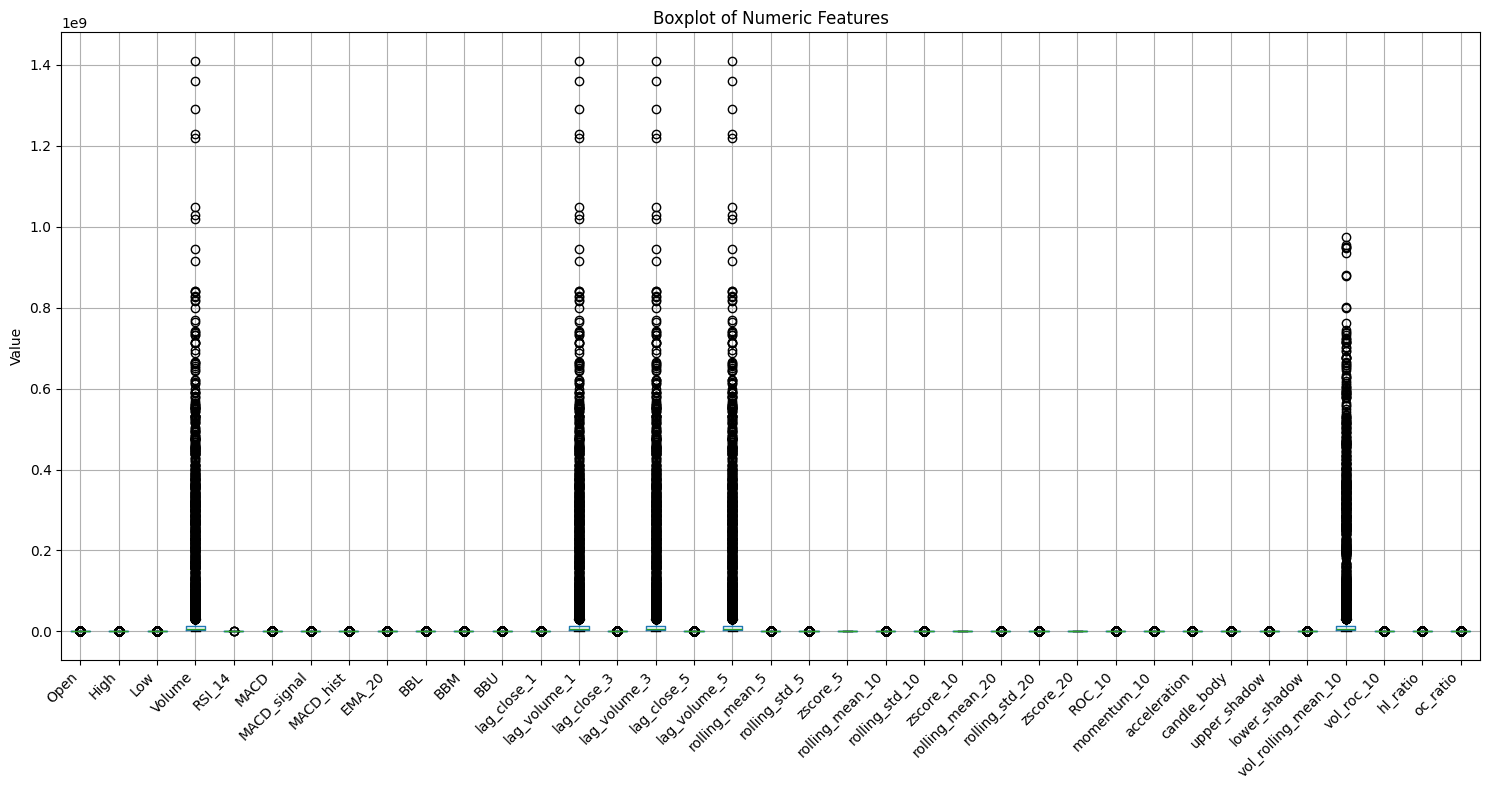

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Columns to exclude from boxplot (identifiers, datetime, target)
exclude_cols = ['Date', 'ticker', 'stock_id', 'Close', 'Price']

# Select numerical columns for boxplot
num_cols = [col for col in final_df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(final_df[col])]

# Plot boxplots for each numeric feature
plt.figure(figsize=(15, 8))
final_df[num_cols].boxplot(rot=90)
plt.title('Boxplot of Numeric Features')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


BoxPlot interpreting before and after Outlier Treatment

Boxplots before outlier removal:


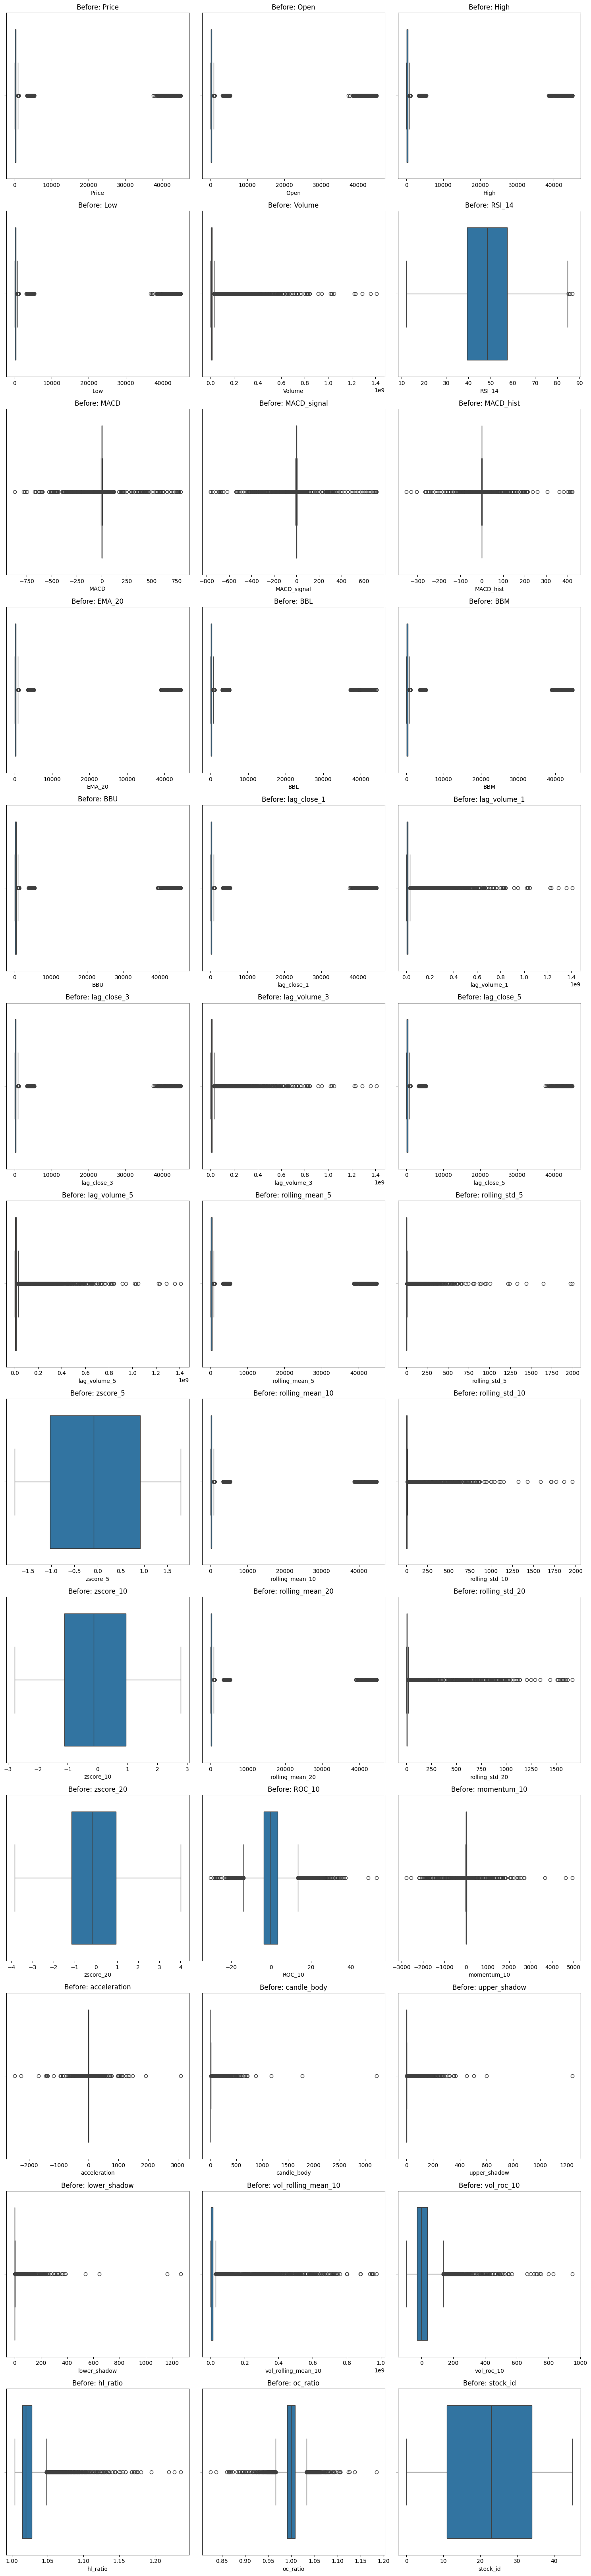

Boxplots after outlier removal:


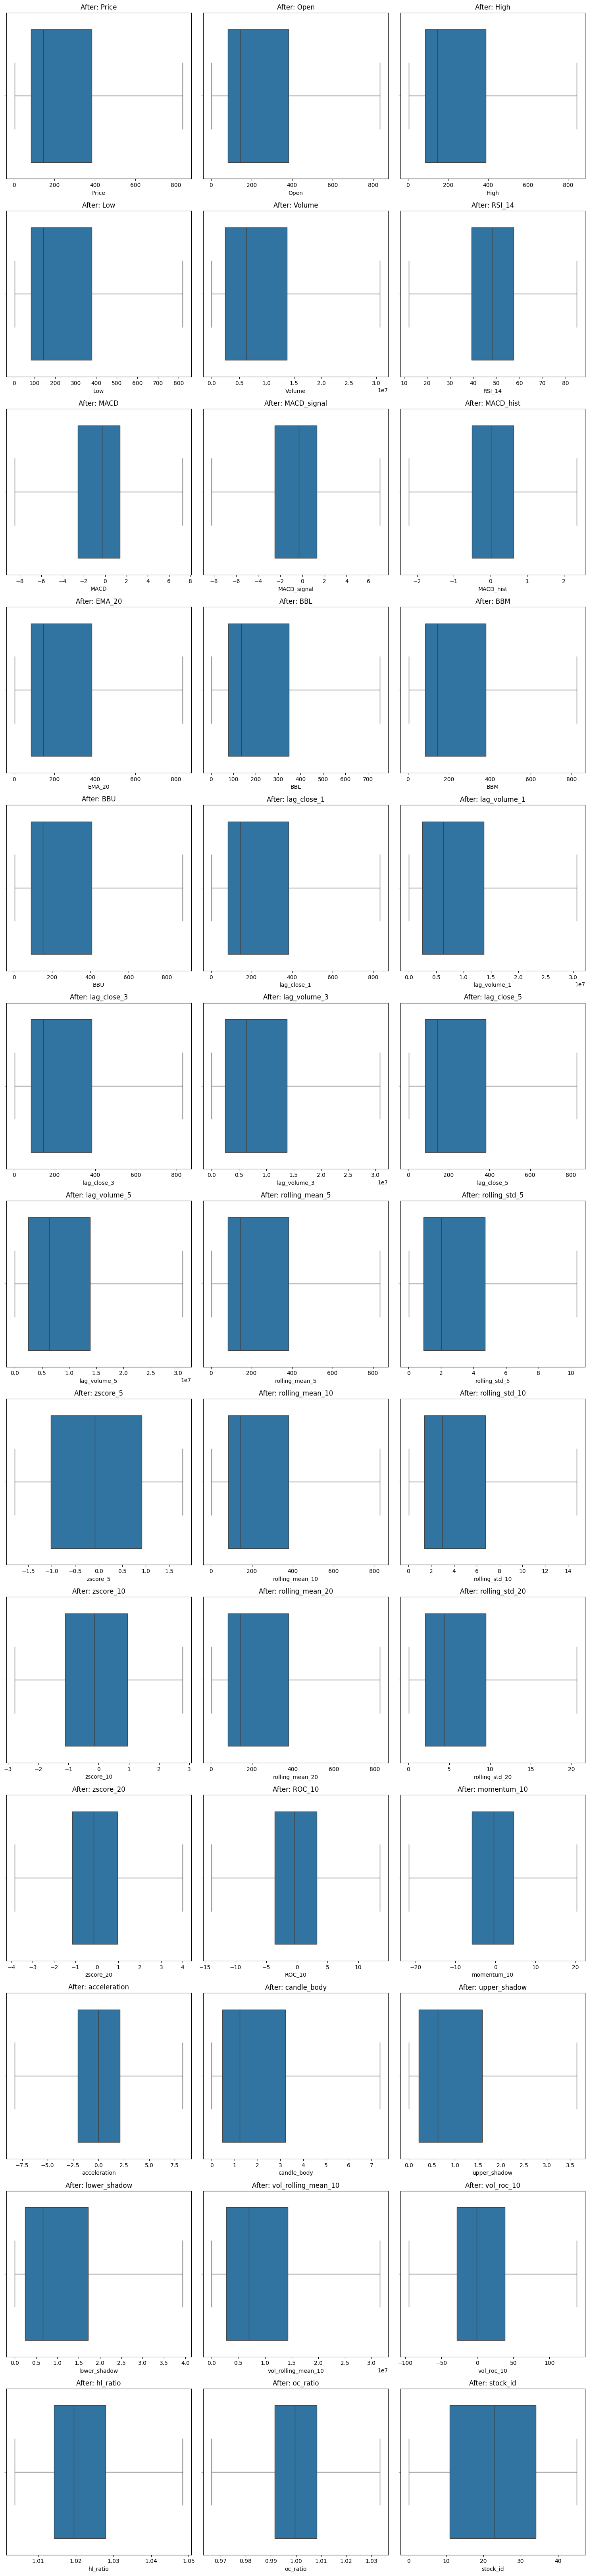

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns except 'Date', 'ticker', and target 'Close'
numeric_cols = final_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
exclude_cols = ['Close']  # You can exclude or include target as per your choice
cols_to_plot = [col for col in numeric_cols if col not in exclude_cols]

# 1. Plot boxplots before outlier treatment
print("Boxplots before outlier removal:")
plt.figure(figsize=(15, 5 * len(cols_to_plot)//3))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot((len(cols_to_plot)+2)//3, 3, i)
    sns.boxplot(x=final_df[col])
    plt.title(f'Before: {col}')
plt.tight_layout()
plt.show()


# 2. Function to cap outliers using IQR method
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply outlier capping for all selected numeric columns
for col in cols_to_plot:
    final_df = cap_outliers_iqr(final_df, col)


# 3. Plot boxplots after outlier treatment
print("Boxplots after outlier removal:")
plt.figure(figsize=(15, 5 * len(cols_to_plot)//3))
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot((len(cols_to_plot)+2)//3, 3, i)
    sns.boxplot(x=final_df[col])
    plt.title(f'After: {col}')
plt.tight_layout()
plt.show()


Checking if parameters are Normally distributed

In [9]:
from scipy.stats import normaltest

normality_results = []

for col in numeric_cols:
    if col not in ['ticker', 'Date', 'stock_id']:  # Exclude non-numeric/categorical
        col_data = final_df[col].dropna()
        if len(col_data) > 8:
            stat, p = normaltest(col_data)
            normality_results.append({
                'Feature': col,
                'Stat': round(stat, 4),
                'p-value': f"{p:.2e}",  # scientific notation like 3.21e-10
                'Normal?': 'Yes' if p > 0.05 else 'No'
            })

normality_df = pd.DataFrame(normality_results)
normal_features = normality_df[normality_df['Normal?'] == 'Yes']

print(f"\n✅ {len(normal_features)} features are normally distributed out of {len(normality_df)} tested numeric features.\n")
display(normality_df)



✅ 0 features are normally distributed out of 39 tested numeric features.



,Feature,Stat,p-value,Normal?
0,Price,1852.4598,0.00e+00,No
1,Open,1847.8495,0.00e+00,No
2,High,1860.1387,0.00e+00,No
3,Low,1834.1941,0.00e+00,No
4,Volume,1420.2006,4.05e-309,No
5,Close,11814.1355,0.00e+00,No
6,RSI_14,262.4851,1.00e-57,No
7,MACD,59.9791,9.46e-14,No
8,MACD_signal,80.6396,3.09e-18,No
9,MACD_hist,17.6202,1.49e-04,No


Calculating Correlation Coefficient

In [10]:
from scipy.stats import spearmanr

correlation_results = []

for col in numeric_cols:
    if col not in ['ticker', 'Date', 'stock_id'] and col != 'Close':
        x = final_df[col].dropna()
        y = final_df['Close'].loc[x.index].dropna()

        # Align both x and y
        aligned = pd.concat([x, y], axis=1).dropna()
        if aligned.shape[0] > 10:
            corr, p = spearmanr(aligned.iloc[:, 0], aligned.iloc[:, 1])
            correlation_results.append({
                'Feature': col,
                'Spearman Corr': round(corr, 4),
                'p-value': f"{p:.2e}",
                'Significant?': 'Yes' if p < 0.05 else 'No'
            })

corr_df = pd.DataFrame(correlation_results)
display(corr_df.sort_values(by='Spearman Corr', ascending=False))


,Feature,Spearman Corr,p-value,Significant?
0,Price,0.9998,0.00e+00,Yes
2,High,0.9997,0.00e+00,Yes
3,Low,0.9997,0.00e+00,Yes
1,Open,0.9996,0.00e+00,Yes
13,lag_close_1,0.9995,0.00e+00,Yes
19,rolling_mean_5,0.9994,0.00e+00,Yes
22,rolling_mean_10,0.9989,0.00e+00,Yes
15,lag_close_3,0.9988,0.00e+00,Yes
9,EMA_20,0.9986,0.00e+00,Yes
17,lag_close_5,0.9982,0.00e+00,Yes


Performing Hypothesis Testing

In [11]:
from scipy.stats import mannwhitneyu

hypothesis_results = []

for col in numeric_cols:
    if col not in ['ticker', 'Date', 'stock_id', 'Close']:
        temp = final_df[[col, 'Close']].dropna()
        if temp.shape[0] > 20:
            # Split based on feature's median
            median = temp[col].median()
            group1 = temp[temp[col] <= median]['Close']
            group2 = temp[temp[col] > median]['Close']

            stat, p = mannwhitneyu(group1, group2, alternative='two-sided')

            hypothesis_results.append({
                'Feature': col,
                'Mann-Whitney p-value': p,
                'Reject H₀?': 'Yes' if p < 0.05 else 'No'
            })

# Convert to DataFrame
hypothesis_df = pd.DataFrame(hypothesis_results)

# Print results in readable format
print(f"\n{'Feature':<25}{'Mann-Whitney p-value':<25}{'Reject H₀?'}")
print("-" * 65)
for _, row in hypothesis_df.iterrows():
    print(f"{row['Feature']:<25}{row['Mann-Whitney p-value']:<25.4e}{row['Reject H₀?']}")



Feature                  Mann-Whitney p-value     Reject H₀?
-----------------------------------------------------------------
Price                    0.0000e+00               Yes
Open                     0.0000e+00               Yes
High                     0.0000e+00               Yes
Low                      0.0000e+00               Yes
Volume                   1.2567e-204              Yes
RSI_14                   1.6850e-05               Yes
MACD                     2.9497e-65               Yes
MACD_signal              9.0321e-83               Yes
MACD_hist                2.5127e-04               Yes
EMA_20                   0.0000e+00               Yes
BBL                      0.0000e+00               Yes
BBM                      0.0000e+00               Yes
BBU                      0.0000e+00               Yes
lag_close_1              0.0000e+00               Yes
lag_volume_1             5.6949e-204              Yes
lag_close_3              0.0000e+00               Yes
lag_volu

Understanding feature wise significance on close price using Man-Whitney Test

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


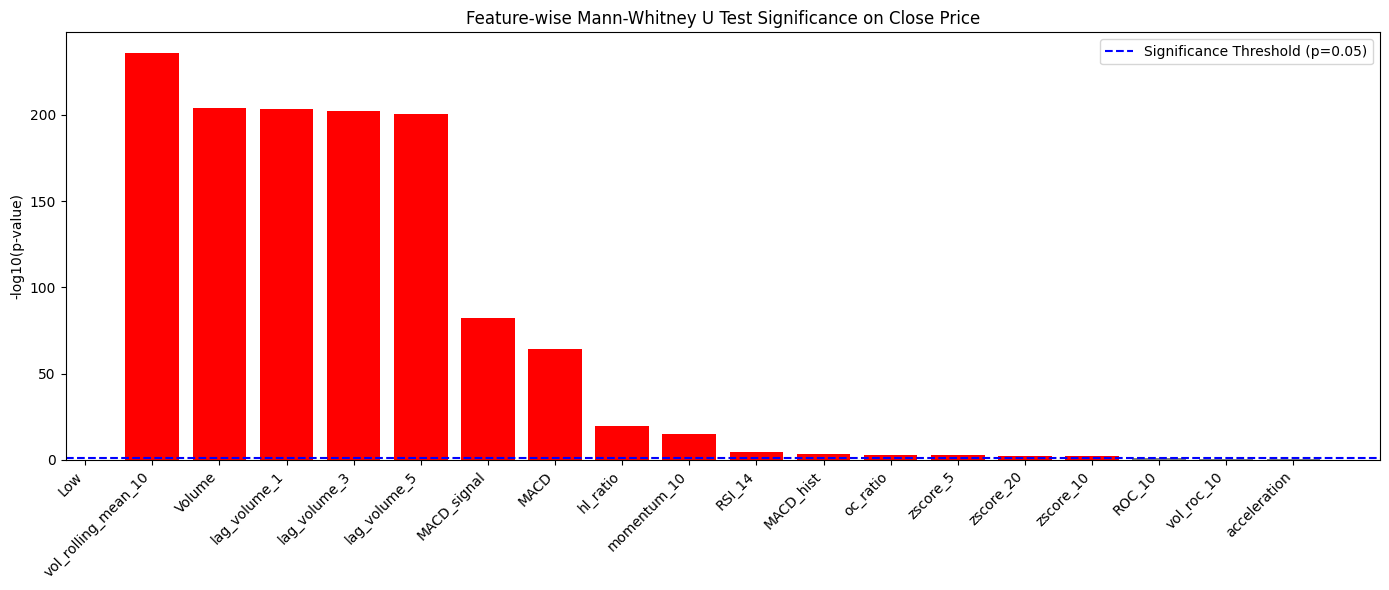

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Create -log10(p-value) for better visualization
hypothesis_df['-log10(p-value)'] = -np.log10(hypothesis_df['Mann-Whitney p-value'])

# Sort for readability
hypothesis_df_sorted = hypothesis_df.sort_values('-log10(p-value)', ascending=False)

# Colors: red if significant (Reject H₀), gray otherwise
colors = ['red' if reject == 'Yes' else 'gray' for reject in hypothesis_df_sorted['Reject H₀?']]

# Plotting
plt.figure(figsize=(14, 6))
bars = plt.bar(hypothesis_df_sorted['Feature'], hypothesis_df_sorted['-log10(p-value)'], color=colors)

# Threshold line for p=0.05 (i.e., -log10(0.05))
plt.axhline(-np.log10(0.05), color='blue', linestyle='--', label='Significance Threshold (p=0.05)')

# Labels & rotation
plt.xticks(rotation=45, ha='right')
plt.ylabel('-log10(p-value)')
plt.title('Feature-wise Mann-Whitney U Test Significance on Close Price')
plt.legend()
plt.tight_layout()

plt.show()


Dropping Features based on Man-Whitney Hypothesis Test Results

In [7]:
# Drop specified columns
final_df.drop(columns=['ROC_10', 'acceleration', 'vol_roc_10'], inplace=True)

# Confirm they're removed
print("Remaining columns:", final_df.columns.tolist())


Remaining columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'ticker', 'Volume', 'Close', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist', 'EMA_20', 'BBL', 'BBM', 'BBU', 'lag_close_1', 'lag_volume_1', 'lag_close_3', 'lag_volume_3', 'lag_close_5', 'lag_volume_5', 'rolling_mean_5', 'rolling_std_5', 'zscore_5', 'rolling_mean_10', 'rolling_std_10', 'zscore_10', 'rolling_mean_20', 'rolling_std_20', 'zscore_20', 'momentum_10', 'candle_body', 'upper_shadow', 'lower_shadow', 'vol_rolling_mean_10', 'hl_ratio', 'oc_ratio', 'stock_id']


Create Binary Target Close_next_day

In [10]:
# 2️⃣ Create target column for next day's close per stock
final_df['Close_next_day'] = final_df.groupby('stock_id')['Close'].shift(-1)

# 3️⃣ Drop rows with NaN in target (last row per stock)
final_df = final_df.dropna(subset=['Close_next_day'])

Train Multiple Models and Fine-Tune each model

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 1️⃣ Create binary target (1 = price up next day, 0 = down or same)
final_df['direction'] = (final_df['Close_next_day'] > final_df['Close']).astype(int)

# 2️⃣ Feature selection
exclude_cols = ['Date','Price', 'Close', 'Close_next_day', 'direction']
X_cols = [col for col in final_df.select_dtypes(include='number').columns if col not in exclude_cols]

# 3️⃣ Grouped train/test split
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

for _, group in final_df.groupby('stock_id'):
    split = int(len(group) * 0.8)
    X_train_list.append(group.iloc[:split][X_cols])
    X_test_list.append(group.iloc[split:][X_cols])
    y_train_list.append(group.iloc[:split]['direction'])
    y_test_list.append(group.iloc[split:]['direction'])

X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

# 4️⃣ Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5️⃣ Models
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [100], 'max_depth': [None, 10]}
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {'C': [0.1, 1]}
    },
    'SVM': {
        'model': SVC(),
        'params': {'C': [1], 'kernel': ['rbf']}
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3]}
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {'n_estimators': [50], 'learning_rate': [1.0]}
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

# 6️⃣ Train & store everything
results = []
all_model_results = {}

for name, mp in models.items():
    print(f"🔍 Tuning and training {name}...")
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train_scaled, y_train)

    # Predict on train & test
    y_train_pred = clf.predict(X_train_scaled)
    y_test_pred = clf.predict(X_test_scaled)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Save everything
    all_model_results[name] = {
        'best_estimator': clf.best_estimator_,
        'best_params': clf.best_params_,
        'y_true_train': y_train,
        'y_pred_train': y_train_pred,
        'y_true_test': y_test,
        'y_pred_test': y_test_pred,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'train_f1': train_report['1']['f1-score'],
        'test_f1': test_report['1']['f1-score'],
        'full_train_report': train_report,
        'full_test_report': test_report
    }

    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Train Precision (1)': train_report['1']['precision'],
        'Train Recall (1)': train_report['1']['recall'],
        'Train F1 (1)': train_report['1']['f1-score'],
        'Test Precision (1)': test_report['1']['precision'],
        'Test Recall (1)': test_report['1']['recall'],
        'Test F1 (1)': test_report['1']['f1-score'],
        'Train Precision (0)': train_report['0']['precision'],
        'Train Recall (0)': train_report['0']['recall'],
        'Train F1 (0)': train_report['0']['f1-score'],
        'Test Precision (0)': test_report['0']['precision'],
        'Test Recall (0)': test_report['0']['recall'],
        'Test F1 (0)': test_report['0']['f1-score'],
        'Test Support (0)': test_report['0']['support'],
        'Test Support (1)': test_report['1']['support']
    })

# (Re)build result_df if needed
result_df = pd.DataFrame(results).sort_values(by='Test F1 (1)', ascending=False).reset_index(drop=True)

# 9️⃣ Print summary
print("🏁 Summary Results:")
print(result_df.to_string(index=False))


🔍 Tuning and training RandomForest...
🔍 Tuning and training LogisticRegression...
🔍 Tuning and training SVM...
🔍 Tuning and training XGBoost...
🔍 Tuning and training GradientBoosting...
🔍 Tuning and training AdaBoost...
🔍 Tuning and training NaiveBayes...
🏁 Summary Results:
             Model  Train Accuracy  Test Accuracy  Train Precision (1)  Train Recall (1)  Train F1 (1)  Test Precision (1)  Test Recall (1)  Test F1 (1)  Train Precision (0)  Train Recall (0)  Train F1 (0)  Test Precision (0)  Test Recall (0)  Test F1 (0)  Test Support (0)  Test Support (1)
      RandomForest        0.877564       0.828947             0.879390          0.860416      0.869799            0.823210         0.812634     0.817888             0.875976          0.893098      0.884455            0.833966         0.843570     0.838740            1042.0             934.0
          AdaBoost        0.838567       0.828441             0.834729          0.823388      0.829020            0.821622         0.813704  

Overfitting Check Through Bar-Graph

/tmp/ipython-input-25-4018655511.py:31: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


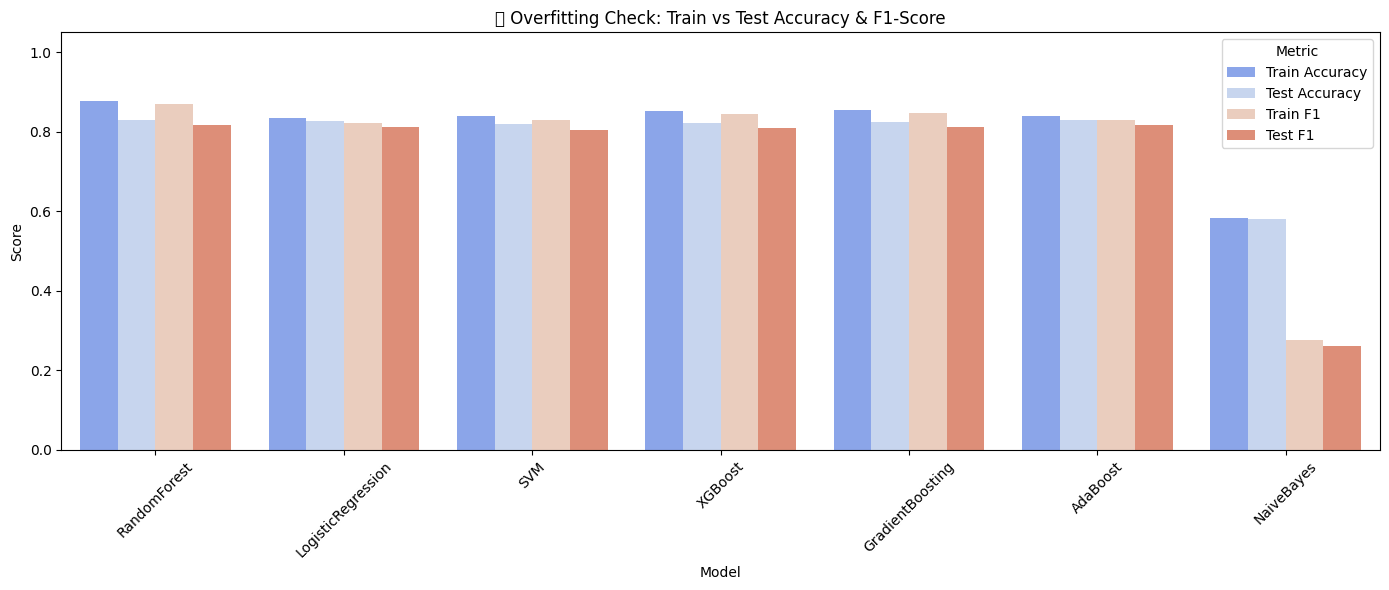

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📦 Build summary DataFrame from stored results
train_test_df = pd.DataFrame([
    {
        'Model': model,
        'Train Accuracy': all_model_results[model]['train_accuracy'],
        'Test Accuracy': all_model_results[model]['test_accuracy'],
        'Train F1': all_model_results[model]['train_f1'],
        'Test F1': all_model_results[model]['test_f1'],
    }
    for model in all_model_results
])

# 🔁 Melt for easy plotting
train_test_df_melted = train_test_df.melt(
    id_vars='Model',
    var_name='Metric',
    value_name='Score'
)

# 🎨 Bar plot
plt.figure(figsize=(14, 6))
sns.barplot(data=train_test_df_melted, x='Model', y='Score', hue='Metric', palette='coolwarm')
plt.title('🧪 Overfitting Check: Train vs Test Accuracy & F1-Score')
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


In [26]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

print("🔁 Performing Stratified K-Fold CV on all models...\n")

for model_name, info in all_model_results.items():
    model = info['best_estimator']

    if hasattr(model, "fit"):
        try:
            scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1', n_jobs=-1)
            mean_score = scores.mean()
            std_score = scores.std()

            cv_results.append({
                'Model': model_name,
                'F1 Mean': mean_score,
                'F1 Std': std_score
            })

            print(f"{model_name}: F1 Score = {mean_score:.4f} ± {std_score:.4f}")

        except Exception as e:
            print(f"⚠️ Error with {model_name}: {e}")

cv_df = pd.DataFrame(cv_results).sort_values(by='F1 Mean', ascending=False).reset_index(drop=True)


🔁 Performing Stratified K-Fold CV on all models...

RandomForest: F1 Score = 0.8243 ± 0.0085
LogisticRegression: F1 Score = 0.8218 ± 0.0069
SVM: F1 Score = 0.8163 ± 0.0088
XGBoost: F1 Score = 0.8251 ± 0.0057
GradientBoosting: F1 Score = 0.8252 ± 0.0057
AdaBoost: F1 Score = 0.8271 ± 0.0102
NaiveBayes: F1 Score = 0.3094 ± 0.1235


Checking Overfitting for each model

In [27]:
# Compare CV vs Test F1
insights = []

for model in cv_df['Model']:
    test_f1 = all_model_results[model]['test_f1']
    cv_f1 = cv_df[cv_df['Model'] == model]['F1 Mean'].values[0]
    gap = test_f1 - cv_f1

    risk = (
        '⚠️ Overfit (Test > CV)' if gap > 0.02 else
        '⚠️ CV Bias (CV > Test)' if gap < -0.02 else
        '✅ Well Generalized'
    )

    insights.append({
        'Model': model,
        'Test F1': round(test_f1, 4),
        'CV F1': round(cv_f1, 4),
        'Gap (Test - CV)': round(gap, 4),
        'Overfitting Risk': risk
    })

insights_df = pd.DataFrame(insights).sort_values(by='Gap (Test - CV)', ascending=False)
print(insights_df.to_string(index=False))


             Model  Test F1  CV F1  Gap (Test - CV)       Overfitting Risk
      RandomForest   0.8179 0.8243          -0.0064     ✅ Well Generalized
          AdaBoost   0.8176 0.8271          -0.0094     ✅ Well Generalized
LogisticRegression   0.8118 0.8218          -0.0100     ✅ Well Generalized
               SVM   0.8035 0.8163          -0.0128     ✅ Well Generalized
  GradientBoosting   0.8113 0.8252          -0.0139     ✅ Well Generalized
           XGBoost   0.8087 0.8251          -0.0164     ✅ Well Generalized
        NaiveBayes   0.2618 0.3094          -0.0476 ⚠️ CV Bias (CV > Test)


Accuracy Comparison between all Models

/tmp/ipython-input-28-203881103.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


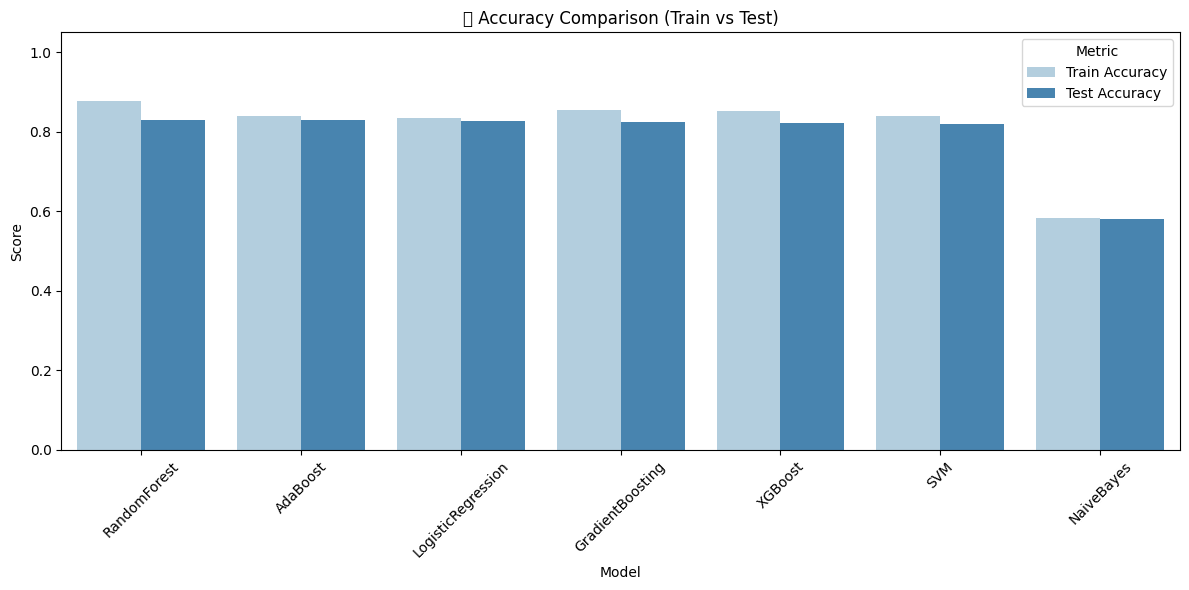

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt for plotting
acc_df = result_df.melt(
    id_vars='Model',
    value_vars=['Train Accuracy', 'Test Accuracy'],
    var_name='Metric',
    value_name='Score'
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=acc_df, x='Model', y='Score', hue='Metric', palette='Blues')
plt.title("📊 Accuracy Comparison (Train vs Test)")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


F1 Score Comparison

📊 F1 Scores of all models (Class 1 - 'price up'):
             Model  Test F1 (1)
      RandomForest     0.817888
          AdaBoost     0.817644
LogisticRegression     0.811816
  GradientBoosting     0.811280
           XGBoost     0.808696
               SVM     0.803522
        NaiveBayes     0.261799


/tmp/ipython-input-29-3876745208.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test F1 (1)', y='Model', data=f1_scores, palette='mako')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


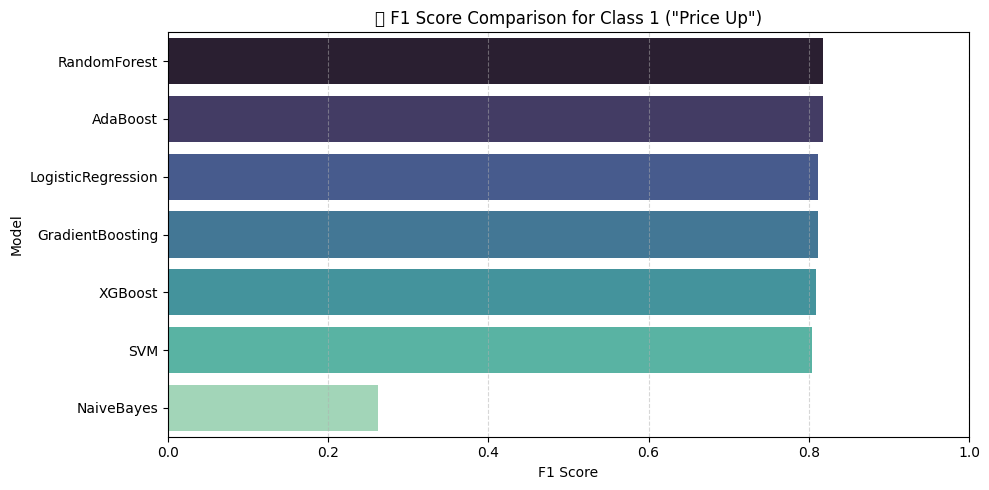

In [29]:
# 📌 Extract F1 Scores of Class 1 from result_df
f1_scores = result_df[['Model', 'Test F1 (1)']].copy()
f1_scores = f1_scores.sort_values(by='Test F1 (1)', ascending=False).reset_index(drop=True)

# 📋 Print F1 Scores
print("📊 F1 Scores of all models (Class 1 - 'price up'):")
print(f1_scores.to_string(index=False))

# 📊 Plot F1 Scores
plt.figure(figsize=(10, 5))
sns.barplot(x='Test F1 (1)', y='Model', data=f1_scores, palette='mako')
plt.title('🔍 F1 Score Comparison for Class 1 ("Price Up")')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.xlim(0.0, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Line Plot (Trends across Models)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


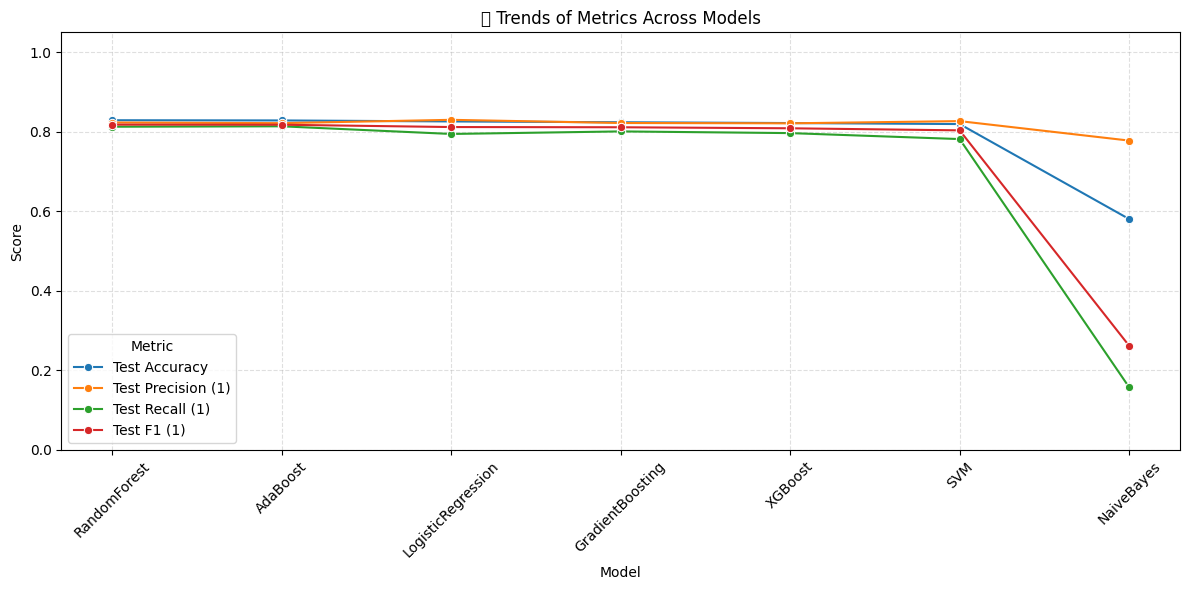

In [30]:
# 📌 Metrics to visualize
metrics_to_plot = ['Test Accuracy', 'Test Precision (1)', 'Test Recall (1)', 'Test F1 (1)']

# 📋 Melt the DataFrame to long-form for seaborn lineplot
melted_df = result_df[['Model'] + metrics_to_plot].melt(id_vars='Model', var_name='Metric', value_name='Score')

# 🔢 Sort models consistently for nice line continuity
melted_df['Model'] = pd.Categorical(melted_df['Model'], categories=result_df['Model'], ordered=True)

# 📈 Plot line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Model', y='Score', hue='Metric', marker='o')
plt.title('📈 Trends of Metrics Across Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0.0, 1.05)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Confusion Matrix for each Model

/tmp/ipython-input-31-1551357394.py:13: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 500x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


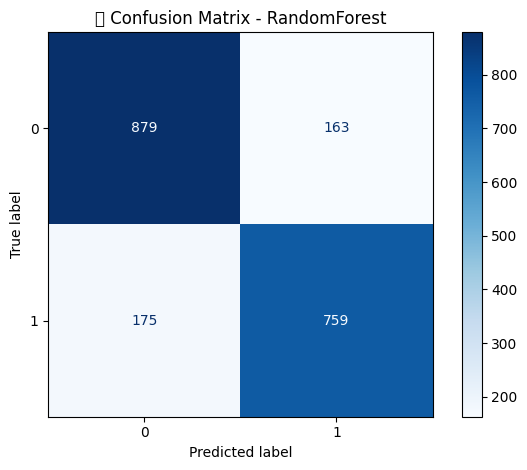

/tmp/ipython-input-31-1551357394.py:13: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 500x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


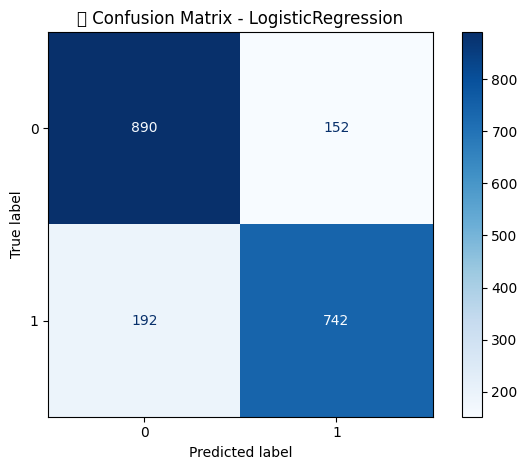

/tmp/ipython-input-31-1551357394.py:13: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 500x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


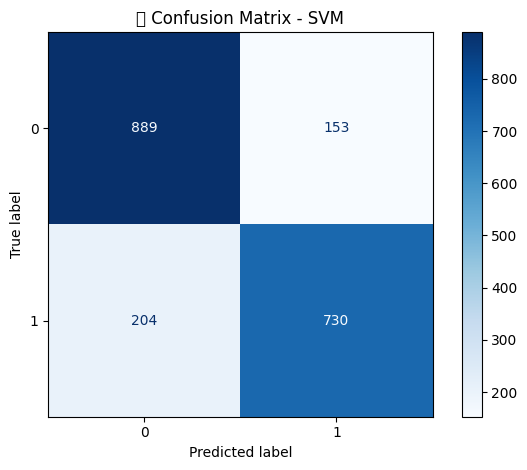

/tmp/ipython-input-31-1551357394.py:13: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 500x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


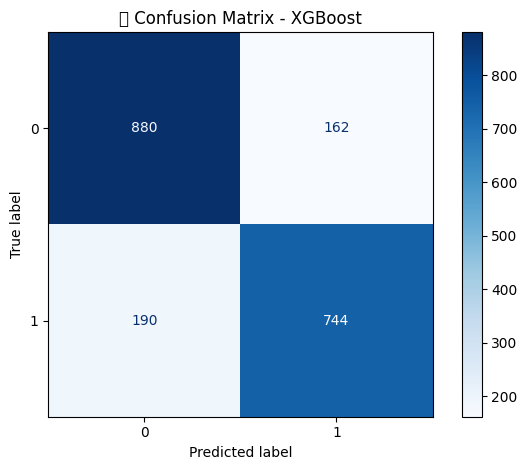

/tmp/ipython-input-31-1551357394.py:13: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 500x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


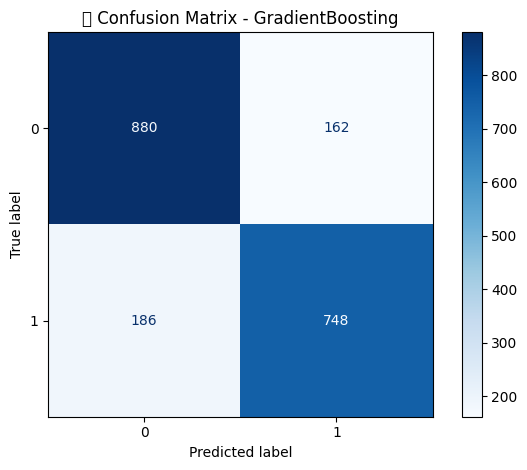

/tmp/ipython-input-31-1551357394.py:13: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 500x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


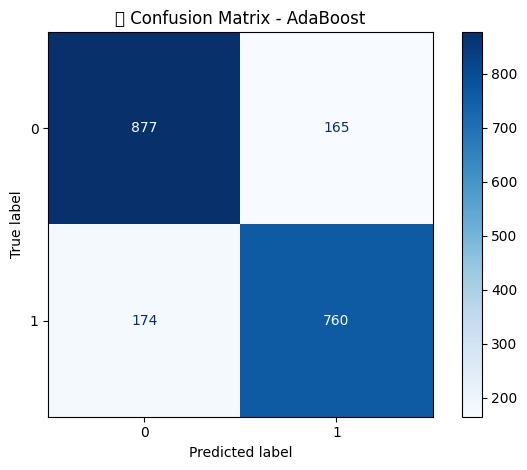

/tmp/ipython-input-31-1551357394.py:13: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 500x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


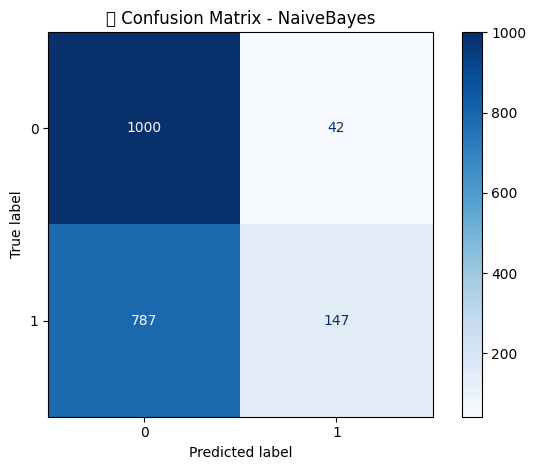

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix for each model
for model_name, info in all_model_results.items():
    cm = confusion_matrix(info['y_true_test'], info['y_pred_test'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    plt.figure(figsize=(5, 4))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"🧮 Confusion Matrix - {model_name}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


ROC-Curve

/tmp/ipython-input-23-1727470298.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


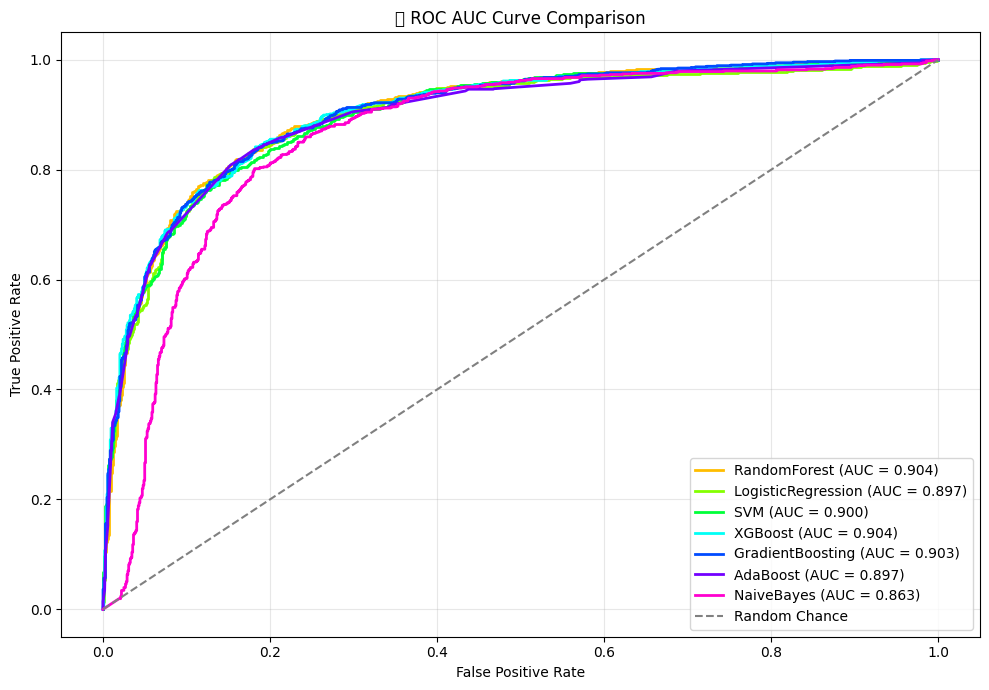

In [23]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))
colors = sns.color_palette("hsv", len(all_model_results))

for i, (model_name, result) in enumerate(all_model_results.items()):
    model = result['best_estimator']

    # ⚠️ Skip models without probability or decision scores
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test_scaled)
    else:
        print(f"Skipping {model_name} (no probability output)")
        continue

    fpr, tpr, _ = roc_curve(result['y_true_test'], y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})', color=colors[i])

# Baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC AUC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


KMeans clustering [Row/date Based Clustering]

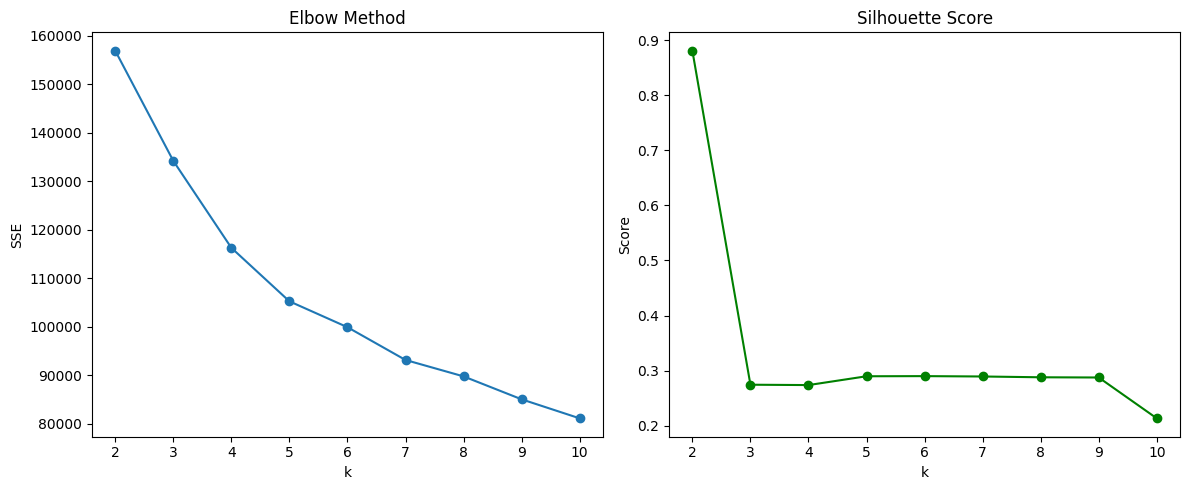

✅ Optimal k: 2

🔹 Training models for Cluster 0
  🔍 RandomForest tuning...
  🔍 LogisticRegression tuning...
  🔍 SVM tuning...
  🔍 XGBoost tuning...
  🔍 GradientBoosting tuning...
  🔍 AdaBoost tuning...
  🔍 NaiveBayes tuning...

🔹 Training models for Cluster 1
  🔍 RandomForest tuning...
  🔍 LogisticRegression tuning...
  🔍 SVM tuning...
  🔍 XGBoost tuning...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:28:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  🔍 GradientBoosting tuning...
  🔍 AdaBoost tuning...
  🔍 NaiveBayes tuning...


,Cluster,Model,Train Accuracy,Test Accuracy,Train F1 (1),Test F1 (1),Train Precision (1),Test Precision (1),Train Recall (1),Test Recall (1),Best Params
0,0,GradientBoosting,0.837988,0.826357,0.828568,0.815991,0.833012,0.818681,0.824170,0.813319,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est..."
1,0,AdaBoost,0.836954,0.826357,0.827284,0.815789,0.832644,0.819383,0.821992,0.812227,"{'learning_rate': 0.5, 'n_estimators': 50}"
2,0,RandomForest,0.884665,0.826357,0.877033,0.815385,0.888547,0.820796,0.865814,0.810044,"{'max_depth': 10, 'n_estimators': 200}"
3,0,XGBoost,0.837083,0.826357,0.827303,0.815385,0.833241,0.820796,0.821448,0.810044,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est..."
4,0,LogisticRegression,0.834109,0.824289,0.821234,0.810901,0.841279,0.826531,0.802123,0.795852,{'C': 0.1}
5,0,SVM,0.835273,0.823773,0.822464,0.809177,0.842661,0.830080,0.803212,0.789301,"{'C': 0.1, 'kernel': 'linear'}"
6,0,NaiveBayes,0.801009,0.791731,0.767908,0.754418,0.861008,0.853793,0.692978,0.675764,{}
7,1,RandomForest,1.000000,0.902439,1.000000,0.882353,1.000000,0.937500,1.000000,0.833333,"{'max_depth': None, 'n_estimators': 200}"
8,1,XGBoost,0.963415,0.902439,0.962025,0.882353,0.974359,0.937500,0.950000,0.833333,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est..."
9,1,GradientBoosting,0.993902,0.853659,0.993711,0.833333,1.000000,0.833333,0.987500,0.833333,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est..."


In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Feature Selection & Scaling
exclude_cols = ['Date', 'Close', 'Close_next_day', 'direction']
X_cols = [col for col in final_df.select_dtypes(include='number').columns if col not in exclude_cols]
X_clust = final_df[X_cols]
scaler_clust = StandardScaler()
X_clust_scaled = scaler_clust.fit_transform(X_clust)

# 2️⃣ Find optimal k
sse, sil = [], []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(X_clust_scaled)
    sse.append(kmeans.inertia_)
    sil.append(silhouette_score(X_clust_scaled, labels))

# Plot elbow & silhouette
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, 'o-'); plt.title("Elbow Method"); plt.xlabel("k"); plt.ylabel("SSE")
plt.subplot(1, 2, 2)
plt.plot(k_range, sil, 'o-', color='green'); plt.title("Silhouette Score"); plt.xlabel("k"); plt.ylabel("Score")
plt.tight_layout(); plt.show()

optimal_k = k_range[np.argmax(sil)]
print(f"✅ Optimal k: {optimal_k}")
final_df['cluster'] = KMeans(n_clusters=optimal_k, n_init='auto', random_state=42).fit_predict(X_clust_scaled)

# 3️⃣ Define fine-tuning models
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10]
        }
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 150],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.5, 1.0]
        }
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

# 4️⃣ Train & fine-tune each model per cluster
cluster_results = []

for c in sorted(final_df['cluster'].unique()):
    print(f"\n🔹 Training models for Cluster {c}")
    cluster_df = final_df[final_df['cluster'] == c]

    # Time-based split
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []
    for _, g in cluster_df.groupby('stock_id'):
        s = int(len(g) * 0.8)
        X_train_list.append(g.iloc[:s][X_cols])
        X_test_list.append(g.iloc[s:][X_cols])
        y_train_list.append(g.iloc[:s]['direction'])
        y_test_list.append(g.iloc[s:]['direction'])

    X_train = pd.concat(X_train_list)
    X_test = pd.concat(X_test_list)
    y_train = pd.concat(y_train_list)
    y_test = pd.concat(y_test_list)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, mp in models.items():
        print(f"  🔍 {name} tuning...")
        clf = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='accuracy', n_jobs=-1)
        clf.fit(X_train_scaled, y_train)

        y_train_pred = clf.predict(X_train_scaled)
        y_test_pred = clf.predict(X_test_scaled)

        train_report = classification_report(y_train, y_train_pred, output_dict=True)
        test_report = classification_report(y_test, y_test_pred, output_dict=True)

        cluster_results.append({
            'Cluster': c,
            'Model': name,
            'Train Accuracy': accuracy_score(y_train, y_train_pred),
            'Test Accuracy': accuracy_score(y_test, y_test_pred),
            'Train F1 (1)': train_report['1']['f1-score'],
            'Test F1 (1)': test_report['1']['f1-score'],
            'Train Precision (1)': train_report['1']['precision'],
            'Test Precision (1)': test_report['1']['precision'],
            'Train Recall (1)': train_report['1']['recall'],
            'Test Recall (1)': test_report['1']['recall'],
            'Best Params': clf.best_params_
        })

# 5️⃣ Results DataFrame
cluster_results_df = pd.DataFrame(cluster_results)
display(cluster_results_df.sort_values(by=['Cluster', 'Test F1 (1)'], ascending=[True, False]).reset_index(drop=True))


Technical insights from KMeans Clustering

cluster,0,1,Difference (1 - 0)
lag_volume_5,17732136.54,4.971977e+08,4.794656e+08
vol_rolling_mean_10,17729037.85,4.963717e+08,4.786427e+08
lag_volume_3,17735930.96,4.936204e+08,4.758845e+08
lag_volume_1,17729784.62,4.908454e+08,4.731156e+08
Volume,17722353.25,4.877851e+08,4.700627e+08
BBU,340.88,4.340847e+04,4.306759e+04
High,322.33,4.214475e+04,4.182242e+04
rolling_mean_20,320.49,4.199100e+04,4.167051e+04
BBM,320.49,4.199100e+04,4.167051e+04
EMA_20,320.69,4.198810e+04,4.166741e+04


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


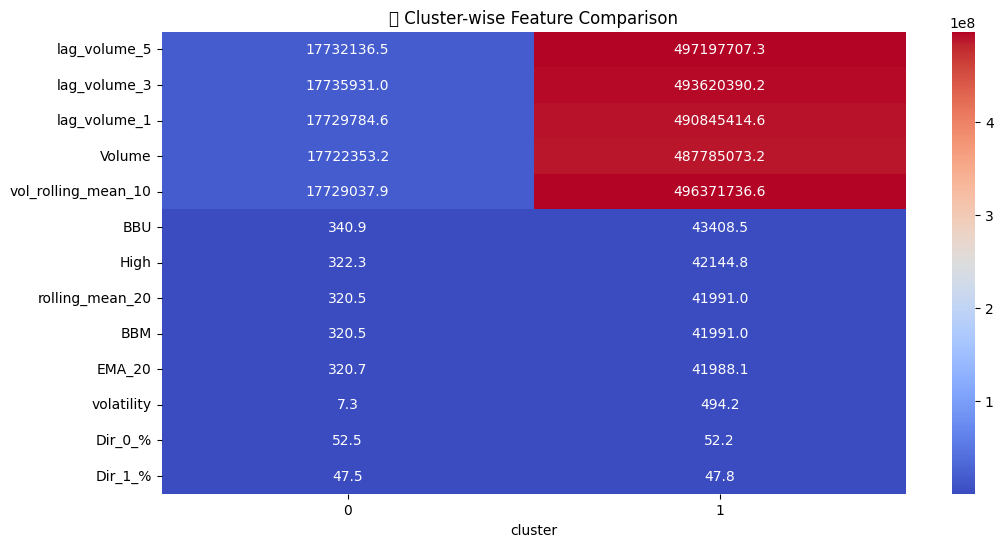


🧠 Cluster Insights:

📈 Cluster 1 has significantly higher 'lag_volume_5' than Cluster 0 (+479465570.78)
📈 Cluster 1 has significantly higher 'lag_volume_3' than Cluster 0 (+475884459.28)
📈 Cluster 1 has significantly higher 'lag_volume_1' than Cluster 0 (+473115630.01)
📈 Cluster 1 has significantly higher 'Volume' than Cluster 0 (+470062719.92)
📈 Cluster 1 has significantly higher 'vol_rolling_mean_10' than Cluster 0 (+478642698.74)
📈 Cluster 1 has significantly higher 'BBU' than Cluster 0 (+43067.59)
📈 Cluster 1 has significantly higher 'High' than Cluster 0 (+41822.42)
📈 Cluster 1 has significantly higher 'rolling_mean_20' than Cluster 0 (+41670.51)
📈 Cluster 1 has significantly higher 'BBM' than Cluster 0 (+41670.51)
📈 Cluster 1 has significantly higher 'EMA_20' than Cluster 0 (+41667.41)
📈 Cluster 1 has significantly higher 'volatility' than Cluster 0 (+486.89)


In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Step 1: Auto-select top N numeric features
N_TOP_FEATURES = 10
exclude_cols = ['Date', 'Close', 'Close_next_day', 'direction', 'cluster', 'stock_id']
numeric_cols = [col for col in final_df.select_dtypes(include='number').columns if col not in exclude_cols]

# Use variance as a proxy for importance
top_features = final_df[numeric_cols].var().sort_values(ascending=False).head(N_TOP_FEATURES).index.tolist()

# 📌 Step 2: Add volatility if available
if 'High' in final_df.columns and 'Low' in final_df.columns and 'volatility' not in final_df.columns:
    final_df['volatility'] = final_df['High'] - final_df['Low']
    top_features.append('volatility')

# 📊 Step 3: Feature means by cluster
feature_means = final_df.groupby('cluster')[top_features].mean().T

# 🧪 Step 4: Target distribution (% up/down) by cluster
direction_dist = final_df.groupby('cluster')['direction'].value_counts(normalize=True).unstack().fillna(0) * 100
direction_dist.columns = [f"Dir_{int(col)}_%" for col in direction_dist.columns]
direction_dist = direction_dist.T

# 📋 Step 5: Build final summary table
summary_table = pd.concat([feature_means, direction_dist], axis=0).round(2)
summary_table['Difference (1 - 0)'] = summary_table[1] - summary_table[0]

# 📊 Step 6: Show interpretation table
display(summary_table.sort_values(by='Difference (1 - 0)', ascending=False))

# 🔥 Step 7: Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(summary_table.drop(columns='Difference (1 - 0)'), annot=True, cmap="coolwarm", fmt=".1f")
plt.title("🧠 Cluster-wise Feature Comparison")
plt.show()

# 🧠 Step 8: Generate natural language insights
print("\n🧠 Cluster Insights:\n")

for feature in summary_table.index:
    diff = summary_table.loc[feature, 'Difference (1 - 0)']
    if abs(diff) >= 5:  # adjustable threshold
        if diff > 0:
            print(f"📈 Cluster 1 has significantly higher '{feature}' than Cluster 0 (+{diff:.2f})")
        else:
            print(f"📉 Cluster 0 has significantly higher '{feature}' than Cluster 1 ({diff:.2f})")


Interpretations From KMeans Clustering [Row/Day based clustering]

In [37]:
import pandas as pd

# 🧠 Technical Cluster Characteristics
insights = [
    ("High volume, lag volumes", "Cluster 1", "Higher trading activity"),
    ("High volatility", "Cluster 1", "More frequent price swings"),
    ("Higher prices (High, EMA_20, BB bands)", "Cluster 1", "Momentum or strong market moves"),
    ("Lower volume and volatility", "Cluster 0", "Stable, less active behavior"),
    ("Lower highs, flat rolling means", "Cluster 0", "Possible consolidation phase")
]

# 📈 Market Regime Interpretation Summary
interpretations = [
    ("Cluster 1", "🔥 High volume, high volatility, higher prices", "⚡ High-activity regime (e.g., bull runs, news shocks, earnings days)"),
    ("Cluster 0", "😴 Low volume, lower volatility, stable prices", "🌥 Calm or accumulation phase (e.g., sideways market, low sentiment)")
]

# Create DataFrames
insight_df = pd.DataFrame(insights, columns=["Observation", "Cluster", "Interpretation"])
regime_df = pd.DataFrame(interpretations, columns=["Cluster", "Characteristics", "Market Regime Interpretation"])

# Display summaries
print("\n📊 Cluster Technical Observations:\n")
print(insight_df.to_string(index=False))

print("\n🌐 Final Market Regime Interpretation:\n")
print(regime_df.to_string(index=False))



📊 Cluster Technical Observations:

                           Observation   Cluster                  Interpretation
              High volume, lag volumes Cluster 1         Higher trading activity
                       High volatility Cluster 1      More frequent price swings
Higher prices (High, EMA_20, BB bands) Cluster 1 Momentum or strong market moves
           Lower volume and volatility Cluster 0    Stable, less active behavior
       Lower highs, flat rolling means Cluster 0    Possible consolidation phase

🌐 Final Market Regime Interpretation:

  Cluster                               Characteristics                                         Market Regime Interpretation
Cluster 1 🔥 High volume, high volatility, higher prices ⚡ High-activity regime (e.g., bull runs, news shocks, earnings days)
Cluster 0 😴 Low volume, lower volatility, stable prices  🌥 Calm or accumulation phase (e.g., sideways market, low sentiment)


In [43]:
from tabulate import tabulate

# Regime interpretation data for Agglomerative Clustering
regime_data = [
    [
        "Cluster 1",
        "🔺 High volume (lag_volume_1/3/5, Volume, vol_rolling_mean_10)\n🔺 High price indicators (BBU, High, EMA_20)\n🔺 Elevated volatility",
        "⚡ High-activity market regime\nE.g., news-driven phases, rallies, or earnings releases",
        "• Bullish rallies\n• Panic-induced drops\n• Sharp trend moves",
        "• Momentum strategies\n• Intraday breakout trades\n• Volatility exploitation"
    ],
    [
        "Cluster 0",
        "🔻 Lower volume and volatility\n🔻 Stable trend indicators (rolling_mean_20, BBM, EMA_20)",
        "🌤 Sideways or accumulation regimes\nE.g., calm markets, ranging zones",
        "• Range-bound trading\n• Pre-breakout phases\n• Accumulation patterns",
        "• Swing trading\n• Mean reversion\n• Position building"
    ]
]

# Column headers
headers = ["Cluster", "Technical Characteristics", "Market Regime Description", "Typical Trading Scenarios", "Suitable Strategies"]

# Print the formatted regime table
print(tabulate(regime_data, headers=headers, tablefmt="fancy_grid"))


╒═══════════╤════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════╤═════════════════════════════╤════════════════════════════╕
│ Cluster   │ Technical Characteristics                                      │ Market Regime Description                               │ Typical Trading Scenarios   │ Suitable Strategies        │
╞═══════════╪════════════════════════════════════════════════════════════════╪═════════════════════════════════════════════════════════╪═════════════════════════════╪════════════════════════════╡
│ Cluster 1 │ 🔺 High volume (lag_volume_1/3/5, Volume, vol_rolling_mean_10) │ ⚡ High-activity market regime                          │ • Bullish rallies           │ • Momentum strategies      │
│           │ 🔺 High price indicators (BBU, High, EMA_20)                   │ E.g., news-driven phases, rallies, or earnings releases │ • Panic-induced drops       │ • Intraday breakout trades │
│           │ 🔺 Elevate

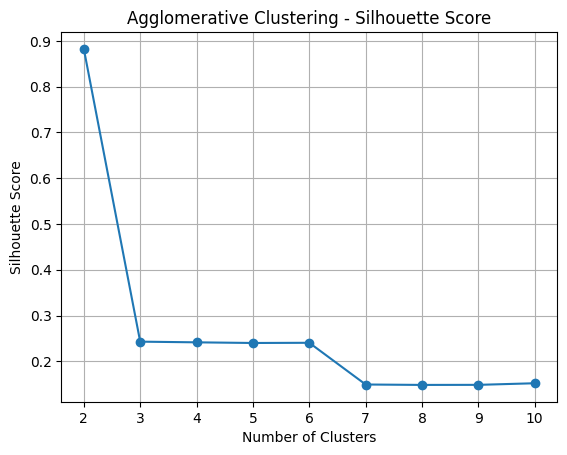

✅ Optimal clusters (k): 2

🔹 Training models for Cluster 0
  🔍 Fine-tuning RandomForest...
  🔍 Fine-tuning LogisticRegression...
  🔍 Fine-tuning SVM...
  🔍 Fine-tuning XGBoost...
  🔍 Fine-tuning GradientBoosting...
  🔍 Fine-tuning AdaBoost...
  🔍 Fine-tuning NaiveBayes...

🔹 Training models for Cluster 1
  🔍 Fine-tuning RandomForest...
  🔍 Fine-tuning LogisticRegression...
  🔍 Fine-tuning SVM...
  🔍 Fine-tuning XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:41:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  🔍 Fine-tuning GradientBoosting...
  🔍 Fine-tuning AdaBoost...
  🔍 Fine-tuning NaiveBayes...

📊 Cluster-wise Model Performance (Agglomerative Clustering):
 Cluster              Model  Train Accuracy  Test Accuracy  Train F1 (1)  Test F1 (1)  Train Precision (1)  Test Precision (1)  Train Recall (1)  Test Recall (1)                                                  Best Params
       0   GradientBoosting        0.837988       0.826357      0.828568     0.815991             0.833012            0.818681          0.824170         0.813319 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
       0            XGBoost        0.836566       0.826357      0.826802     0.815789             0.832506            0.819383          0.821176         0.812227 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
       0           AdaBoost        0.836954       0.826357      0.827284     0.815789             0.832644            0.819383          0.821992         0.812227              

In [39]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Feature selection & scaling
exclude_cols = ['Date', 'Close','Price', 'Close_next_day', 'direction']
X_cols = [col for col in final_df.select_dtypes(include='number').columns if col not in exclude_cols]
X_clust = final_df[X_cols]
scaler_clust = StandardScaler()
X_clust_scaled = scaler_clust.fit_transform(X_clust)

# 2️⃣ Optimal number of clusters via silhouette score
sil_scores = []
k_range = range(2, 11)
for k in k_range:
    labels = AgglomerativeClustering(n_clusters=k).fit_predict(X_clust_scaled)
    sil = silhouette_score(X_clust_scaled, labels)
    sil_scores.append(sil)

plt.plot(k_range, sil_scores, marker='o')
plt.title("Agglomerative Clustering - Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

optimal_k = k_range[np.argmax(sil_scores)]
print(f"✅ Optimal clusters (k): {optimal_k}")

# 3️⃣ Cluster assignment
final_df['agg_cluster'] = AgglomerativeClustering(n_clusters=optimal_k).fit_predict(X_clust_scaled)

# 4️⃣ Define models & hyperparameters
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10]
        }
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 150],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.5, 1.0]
        }
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

# 5️⃣ Train, fine-tune & evaluate models per cluster
cluster_results = []

for c in sorted(final_df['agg_cluster'].unique()):
    print(f"\n🔹 Training models for Cluster {c}")
    cluster_df = final_df[final_df['agg_cluster'] == c]

    # Time-based split
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []
    for _, g in cluster_df.groupby('stock_id'):
        s = int(len(g) * 0.8)
        X_train_list.append(g.iloc[:s][X_cols])
        X_test_list.append(g.iloc[s:][X_cols])
        y_train_list.append(g.iloc[:s]['direction'])
        y_test_list.append(g.iloc[s:]['direction'])

    X_train = pd.concat(X_train_list)
    X_test = pd.concat(X_test_list)
    y_train = pd.concat(y_train_list)
    y_test = pd.concat(y_test_list)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, mp in models.items():
        print(f"  🔍 Fine-tuning {name}...")
        clf = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='accuracy', n_jobs=-1)
        clf.fit(X_train_scaled, y_train)

        y_train_pred = clf.predict(X_train_scaled)
        y_test_pred = clf.predict(X_test_scaled)

        train_report = classification_report(y_train, y_train_pred, output_dict=True)
        test_report = classification_report(y_test, y_test_pred, output_dict=True)

        cluster_results.append({
            'Cluster': c,
            'Model': name,
            'Train Accuracy': accuracy_score(y_train, y_train_pred),
            'Test Accuracy': accuracy_score(y_test, y_test_pred),
            'Train F1 (1)': train_report['1']['f1-score'],
            'Test F1 (1)': test_report['1']['f1-score'],
            'Train Precision (1)': train_report['1']['precision'],
            'Test Precision (1)': test_report['1']['precision'],
            'Train Recall (1)': train_report['1']['recall'],
            'Test Recall (1)': test_report['1']['recall'],
            'Best Params': clf.best_params_
        })

# 6️⃣ Final results
cluster_results_df = pd.DataFrame(cluster_results)
print("\n📊 Cluster-wise Model Performance (Agglomerative Clustering):")
print(cluster_results_df.sort_values(by=['Cluster', 'Test F1 (1)'], ascending=[True, False]).to_string(index=False))


Technical Insights from Agglomerative Clustering

In [41]:
# Step 1: Select numerical features
exclude_cols = ['Date', 'Close', 'Close_next_day', 'direction', 'agg_cluster']
num_cols = [col for col in final_df.select_dtypes(include='number').columns if col not in exclude_cols]

# Step 2: Compute means
cluster_means = final_df.groupby('agg_cluster')[num_cols].mean()

# Step 3: Compute differences between clusters
diffs = (cluster_means.loc[cluster_means.index[1]] - cluster_means.loc[cluster_means.index[0]]).sort_values(key=np.abs, ascending=False)

# Step 4: Format top N insights
top_n = 10
print("🧠 Technical Insights from Agglomerative Clustering:\n")
for feature in diffs.head(top_n).index:
    diff_val = diffs[feature]
    direction = "higher" if diff_val > 0 else "lower"
    print(f"📌 Cluster {cluster_means.index[1] if diff_val > 0 else cluster_means.index[0]} has significantly {direction} '{feature}' than Cluster {cluster_means.index[0] if diff_val > 0 else cluster_means.index[1]} (Δ = {abs(diff_val):,.2f})")


🧠 Technical Insights from Agglomerative Clustering:

📌 Cluster 1 has significantly higher 'lag_volume_5' than Cluster 0 (Δ = 479,465,570.78)
📌 Cluster 1 has significantly higher 'vol_rolling_mean_10' than Cluster 0 (Δ = 478,642,698.74)
📌 Cluster 1 has significantly higher 'lag_volume_3' than Cluster 0 (Δ = 475,884,459.28)
📌 Cluster 1 has significantly higher 'lag_volume_1' than Cluster 0 (Δ = 473,115,630.01)
📌 Cluster 1 has significantly higher 'Volume' than Cluster 0 (Δ = 470,062,719.92)
📌 Cluster 1 has significantly higher 'BBU' than Cluster 0 (Δ = 43,067.59)
📌 Cluster 1 has significantly higher 'High' than Cluster 0 (Δ = 41,822.42)
📌 Cluster 1 has significantly higher 'rolling_mean_20' than Cluster 0 (Δ = 41,670.51)
📌 Cluster 1 has significantly higher 'BBM' than Cluster 0 (Δ = 41,670.51)
📌 Cluster 1 has significantly higher 'EMA_20' than Cluster 0 (Δ = 41,667.41)


Conclusion on each cluster of Agglomerative clustering

In [42]:
from tabulate import tabulate

# Cluster interpretation data
regime_data = [
    [
        "Cluster 1",
        "🔺 High volume (lag_volume_1/3/5, Volume, vol_rolling_mean_10)\n🔺 High price levels (High, BBU, EMA_20)\n🔺 High volatility",
        "⚡ High-activity or volatile phase\nE.g., earnings, news events, trend surges",
        "• Bull runs\n• Panic sell-offs\n• News-driven rallies",
        "• Intraday/Momentum trading\n• Volatility breakout\n• Scalping"
    ],
    [
        "Cluster 0",
        "🔻 Lower volume & volatility\n🔻 Stable price indicators (rolling_mean_20, BBM, EMA_20)",
        "🌤 Calm, sideways, or accumulation phase\nE.g., consolidation or passive markets",
        "• Consolidation\n• Low-sentiment periods\n• Pre-breakout setups",
        "• Swing trading\n• Mean-reversion\n• Long-term entry points"
    ]
]

# Column headers
headers = ["Cluster", "Technical Characteristics", "Market Regime Description", "Typical Trading Scenarios", "Suitable Strategies"]

# Print the table
print(tabulate(regime_data, headers=headers, tablefmt="fancy_grid"))


╒═══════════╤════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════╤═════════════════════════════╤═════════════════════════════╕
│ Cluster   │ Technical Characteristics                                      │ Market Regime Description                 │ Typical Trading Scenarios   │ Suitable Strategies         │
╞═══════════╪════════════════════════════════════════════════════════════════╪═══════════════════════════════════════════╪═════════════════════════════╪═════════════════════════════╡
│ Cluster 1 │ 🔺 High volume (lag_volume_1/3/5, Volume, vol_rolling_mean_10) │ ⚡ High-activity or volatile phase        │ • Bull runs                 │ • Intraday/Momentum trading │
│           │ 🔺 High price levels (High, BBU, EMA_20)                       │ E.g., earnings, news events, trend surges │ • Panic sell-offs           │ • Volatility breakout       │
│           │ 🔺 High volatility                                             │           

Granger-Based Lagged Feature Augmentation for Predictive Modeling

In [87]:
import pandas as pd
import numpy as np
import networkx as nx
import plotly.graph_objs as go
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1️⃣ Prepare returns matrix
id_to_ticker = final_df.groupby('stock_id')['ticker'].first().to_dict()
price_matrix = final_df.pivot(index='Date', columns='stock_id', values='Close').dropna()
returns = np.log(price_matrix / price_matrix.shift(1)).dropna()

# 2️⃣ Compute Granger causality matrix
def granger_matrix(data, maxlag=5):
    stock_ids = data.columns
    result = pd.DataFrame(1.0, index=stock_ids, columns=stock_ids)
    for y in stock_ids:
        for x in stock_ids:
            if x == y: continue
            try:
                test_result = grangercausalitytests(data[[y, x]], maxlag=maxlag, verbose=False)
                p_vals = [test_result[i+1][0]['ssr_ftest'][1] for i in range(maxlag)]
                result.loc[x, y] = min(p_vals)
            except:
                continue
    return result

granger_pvals = granger_matrix(returns)

# 3️⃣ Build NetworkX graph with strong edges only
G = nx.DiGraph()
threshold = 0.005  # tighter threshold
for from_id in granger_pvals.index:
    for to_id in granger_pvals.columns:
        p = granger_pvals.loc[from_id, to_id]
        if p < threshold:
            from_ticker = id_to_ticker[from_id]
            to_ticker = id_to_ticker[to_id]
            G.add_edge(from_ticker, to_ticker, weight=1 - p)

# 4️⃣ Prepare Plotly graph
pos = nx.spring_layout(G, seed=42)
edge_x, edge_y = [], []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

node_x, node_y, hover_text = [], [], []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    out_deg = G.out_degree(node)
    in_deg = G.in_degree(node)
    hover_text.append(f"<b>{node}</b><br>Influences: {out_deg}<br>Influenced by: {in_deg}")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=list(G.nodes()),
    textposition='top center',
    marker=dict(
        showscale=False,
        color='lightblue',
        size=14,
        line=dict(width=2, color='black')
    ),
    hovertext=hover_text,
    hoverinfo='text'
)

# 5️⃣ Plot the graph
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="📊 Interactive Stock Influence Network (Granger Causality)",
                    titlefont_size=18,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))

fig.show()


In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC

# 1️⃣ Compute log returns matrix
price_matrix = final_df.pivot(index='Date', columns='stock_id', values='Close').dropna()
log_returns = np.log(price_matrix / price_matrix.shift(1)).dropna()

# 2️⃣ Build influence map from Granger causality matrix
threshold = 0.05
influence_map = {}
for to_stock in granger_pvals.columns:
    influencers = granger_pvals[granger_pvals[to_stock] < threshold].index.tolist()
    if influencers:
        influence_map[to_stock] = influencers

# 3️⃣ Generate lagged influencer features
influence_features = pd.DataFrame(index=log_returns.index)
for target, influencers in influence_map.items():
    for influencer in influencers:
        col_name = f"{influencer}_influences_{target}"
        influence_features[col_name] = log_returns[influencer].shift(1)

# 4️⃣ Add base return & merge features to final_df
log_return_df = log_returns.stack().reset_index().rename(columns={'level_1': 'stock_id', 0: 'log_return'})
final_df = final_df.merge(log_return_df, on=['Date', 'stock_id'], how='left')
final_df = final_df.merge(influence_features.reset_index(), on='Date', how='left')

# 5️⃣ Drop rows with any missing influencer embeddings
final_df = final_df.dropna(subset=[col for col in final_df.columns if 'influences' in col] + ['log_return'])

# 6️⃣ Define model candidates
models = {
    'XGBoost': {'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 'params': {'n_estimators': [100], 'max_depth': [3]}},
    'LogisticRegression': {'model': LogisticRegression(max_iter=1000), 'params': {'C': [0.1, 1]}},
    'RandomForest': {'model': RandomForestClassifier(), 'params': {'n_estimators': [100], 'max_depth': [10]}},
    'GradientBoosting': {'model': GradientBoostingClassifier(), 'params': {'n_estimators': [100], 'max_depth': [3]}},
    'SVM': {'model': SVC(probability=True), 'params': {'C': [1], 'kernel': ['rbf']}},
    'NaiveBayes': {'model': GaussianNB(), 'params': {}}
}

# 7️⃣ Prepare training data
X_cols = [col for col in final_df.select_dtypes(include='number').columns if col not in ['Close_next_day', 'direction']]
X = final_df[X_cols]
y = final_df['direction']

# Time-based train-test split
final_df_sorted = final_df.sort_values('Date')
split_idx = int(len(final_df_sorted) * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8️⃣ Train & evaluate models
results = []

for name, mp in models.items():
    print(f"\n🔍 Training {name}...")
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score (1)': report['1']['f1-score'],
        'Precision (1)': report['1']['precision'],
        'Recall (1)': report['1']['recall'],
        'Best Params': clf.best_params_
    })

# 9️⃣ Final Result Table
results_df = pd.DataFrame(results).sort_values(by='F1 Score (1)', ascending=False)
print("\n📊 Final Results with Influencer Embeddings:")
print(results_df.to_string(index=False))



🔍 Training XGBoost...

🔍 Training LogisticRegression...

🔍 Training RandomForest...

🔍 Training GradientBoosting...

🔍 Training SVM...

🔍 Training NaiveBayes...

📊 Final Results with Influencer Embeddings:
             Model  Accuracy  F1 Score (1)  Precision (1)  Recall (1)                            Best Params
  GradientBoosting  0.861565      0.859846       0.848308    0.871703  {'max_depth': 3, 'n_estimators': 100}
           XGBoost  0.860981      0.858502       0.851415    0.865707  {'max_depth': 3, 'n_estimators': 100}
LogisticRegression  0.841706      0.836056       0.843712    0.828537                             {'C': 0.1}
               SVM  0.817173      0.803268       0.844122    0.766187              {'C': 1, 'kernel': 'rbf'}
      RandomForest  0.801402      0.789082       0.817481    0.762590 {'max_depth': 10, 'n_estimators': 100}
        NaiveBayes  0.575935      0.402961       0.641361    0.293765                                     {}
